# ML- version modules Picrust2

Pour la prédiction du rdm total ou rdm normalisé (selon les variétés de PDT)

## Importation des librairies

In [1]:
import os
import pandas as pd
import math
import shap
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display, Markdown, Latex
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
import torch
from torch.nn import functional as F

from skopt.plots import plot_convergence, plot_evaluations, plot_objective, plot_regret
from sklearn.feature_selection import SelectPercentile, SelectFromModel
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import QuantileTransformer
os.makedirs('results', exist_ok=True)
from tqdm.notebook import tqdm as tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split

experiment_name = 'acne_500k'
n_features = -1

In [2]:
np.random.seed(42)


In [3]:
def augment_data(X_train, y_train, n_aug, p=0, g=0):
    torch.manual_seed(42)
    X_train2 = X_train.copy()
    y_train2 = y_train.copy()
    colnames = X_train.columns
    # y_train2 = np.array([])
    # X_train2 = np.array([])

    if n_aug > 0:
        for _ in range(n_aug):
            y_train2 = np.concatenate([y_train2, y_train])
            tmp = X_train.copy() + g * np.random.normal(0, 1, X_train.shape)
            tmp = tmp.astype(np.float64)

            arr = torch.from_numpy(np.array(tmp).copy())
            tmp = F.dropout(arr, p).detach().cpu().numpy()
            if len(X_train2) > 0:
                X_train2 = np.concatenate([X_train2, tmp], 0)
            else:
                X_train2 = tmp
    X_train2 = pd.DataFrame(X_train2, columns=colnames)
    return X_train2, y_train2

In [4]:
def get_scaler(scaler):
    if scaler == 'robust':
        return RobustScaler
    elif scaler == 'none' or scaler is None or scaler == 'binary':
        return None
    elif scaler == 'standard':
        return StandardScaler
    elif scaler == 'minmax':
        return MinMaxScaler
    else:
        exit('Wrong scaler name')

In [5]:
class Train:
    def __init__(self, model, model_name, exp_name, data, hparams_names, mi, n_splits, n_calls):
        self.model = model
        self.name = model_name
        self.exp_name = exp_name
        self.data = data
        self.hparams_names = hparams_names
        self.h_params = None
        self.best_test_scores = None
        self.n_splits = n_splits
        self.mi = mi
        self.iter = 0
        self.pbar = tqdm(range(n_calls), position=0, leave=True)
        self.best_score = -np.inf
        if 'bagging' in model_name:
            self.bagging = True
        else:
            self.bagging = False
        

    def train(self, h_params):
        self.iter += 1
        bag = 1
        features_cutoff = None
        param_grid = {}
        ensemble_grid = {}
        n_aug = 3  # default if not specified in hparams
        scaler = 'standard' # default if not specified in hparams
        for name, param in zip(self.hparams_names, h_params):
            # The number of augmentation to use is optimized
            if self.bagging:
                if name != 'n_aug' and bag:
                    ensemble_grid[name] = param
                    continue
                else:
                    bag = 0
            if name == 'n_aug':
                n_aug = param
            elif name == 'p':
                p = param
            elif name == 'g':
                g = param
            # Many scalers are "optimized" during the hparams optimization. 
            elif name == 'scaler':
                scaler = param
            elif name == 'features_cutoff':
                features_cutoff = param
            elif name == 'zeros_cutoff':
                zeros_cutoff = param
            else:
                param_grid[name] = param        
        # print hparams and their names
        # Make dict of hparams
        h_params_dict = {name: param for name, param in zip(self.hparams_names, h_params)}
        print('hparams:', h_params_dict)

        X = self.data['X'].copy()
        clusters = self.data['clusters']
        # Keep features with mi only up to features_cutoff. mis are ordered in descending order
        features_cutoff = int(X.shape[1] * features_cutoff)
        X = X.iloc[:, self.mi[:features_cutoff]].copy()

        # This function returns the scaler from a string
        scaler = get_scaler(scaler)

        X = X.loc[:, (X != 0).mean() > zeros_cutoff].copy()
        if X.shape[0] == 0:
            return 1
        if scaler is not None and scaler != 'none' and scaler != 'binary':
            scaler = scaler()
            try:
                X.iloc[:] = scaler.fit_transform(X)
            except:
                return 1
        elif scaler == 'binary':
            X = X.applymap(lambda x: 1 if x > 0.5 else 0)
        # Shuffle is False by default, but just in case it ever changes
        # Shuffle needs to be False. For each iteration of the hparam optimization, the splits must always 
        # be exactly the same for a fair comparison. 
        scores = { 
            group: {
                'acc': [], 
                'mcc': [],
                'ari': [],
                'ami': [],
                'precision': [],
                'TPR': [],
                'FPR': [],
                'TNR': [],
                'FNR': [],
                'informedness': [],
                'kappa': [],
                'f1': [],
                'cluster_metrics': {
                    'acc': {1: [], 2: [], 0: []},
                    'mcc': {1: [], 2: [], 0: []},
                    'ari': {1: [], 2: [], 0: []},
                    'ami': {1: [], 2: [], 0: []}
                }
            } for group in ['train', 'valid', 'test']
        }
        preds_dict = {group: [] for group in ['train', 'valid', 'test']}
        ys_dict = {group: [] for group in ['train', 'valid', 'test']}
        h = 0
        while h < self.n_splits:                                
            print(h)
            skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
            train_nums = np.arange(0, len(self.data['y']))
            splitter = skf.split(train_nums, self.data['y'], self.data['clusters'])
            if h > 0 and h < self.n_splits - 1:
                for i in range(h):
                    _, _ = splitter.__next__()
                _, valid_inds = splitter.__next__()
                _, test_inds = splitter.__next__()

            elif h == self.n_splits - 1:
                _, test_inds = splitter.__next__()
                for i in range(h-1):
                    _, _ = splitter.__next__()
                _, valid_inds = splitter.__next__()
            else:
                _, valid_inds = splitter.__next__()
                _, test_inds = splitter.__next__()

            train_inds = [x for x in train_nums if x not in np.concatenate((valid_inds, test_inds))]

            reg = self.model
            if self.bagging:
                reg.base_estimator.set_params(**ensemble_grid)
            reg.set_params(**param_grid)
            ys = {group: self.data['y'].iloc[inds].copy() for group, inds in \
                  zip(['train', 'valid', 'test'], [train_inds, valid_inds, test_inds])}
            cs = {group: clusters[inds] for group, inds in \
                    zip(['train', 'valid', 'test'], [train_inds, valid_inds, test_inds])}
            Xs = {group: X.iloc[inds].copy() for group, inds in \
                    zip(['train', 'valid', 'test'], [train_inds, valid_inds, test_inds])}
            
            # y_train = self.data['y'].iloc[train_inds].copy()
            # y_valid = self.data['y'].iloc[valid_inds].copy()
            # y_test = self.data['y'].iloc[test_inds].copy()
            # c_train = clusters[train_inds]
            # c_valid = clusters[valid_inds]
            # c_test = clusters[test_inds]
            # X_train = X.iloc[train_inds].copy()
            # X_valid = X.iloc[valid_inds].copy()
            # x_test = X.iloc[test_inds].copy()
            
            X_train2, y_train2 = augment_data(Xs['train'], ys['train'], n_aug, p, g)
            if X_train2.shape[1] == 0:
                return 1
            # select = FeatureAgglomeration(n_clusters=64)
            # X_train2 = select.fit_transform(X_train2, y_train2)
            # X_valid = select.transform(X_valid)
            
            try:
                reg = reg.fit(X_train2, y_train2)
                preds = {group: reg.predict(Xs[group]) for group in ['train', 'valid', 'test']}
            except:
                reg = reg.fit(X_train2.values, y_train2)
                preds = {group: reg.predict(Xs[group].values) for group in ['train', 'valid', 'test']}
            for group in ['train', 'valid', 'test']:
                preds_dict[group] += list(preds[group])
                ys_dict[group] += list(ys[group])
            for group in ['train', 'valid', 'test']:
                scores[group]['mcc'] = metrics.matthews_corrcoef(ys[group], preds[group])
                scores[group]['acc'] = accuracy_score(ys[group], preds[group])
                scores[group]['ari'] = metrics.adjusted_rand_score(ys[group], cs[group])
                scores[group]['ami'] = metrics.adjusted_mutual_info_score(ys[group], preds[group])
                scores[group]['precision'] = metrics.precision_score(ys[group], preds[group], average='binary', zero_division=0)
                scores[group]['recall'] = metrics.recall_score(ys[group], preds[group], average='binary')
                scores[group]['f1'] = metrics.f1_score(ys[group], preds[group], average='binary')
                scores[group]['TPR'] = metrics.recall_score(ys[group], preds[group], average='binary')
                scores[group]['TNR'] = metrics.recall_score(ys[group], preds[group], pos_label=0, average='binary')
                scores[group]['FNR'] = 1 - metrics.recall_score(ys[group], preds[group], average='binary')
                scores[group]['FPR'] = 1 - metrics.recall_score(ys[group], preds[group], pos_label=0, average='binary')
                scores[group]['informedness'] = scores[group]['TPR'] + scores[group]['TNR'] - 1
                scores[group]['kappa'] = metrics.cohen_kappa_score(ys['train'], preds['train'])
            
            c_dict = {group: cs[group] for group in ['train', 'valid', 'test']}
            y_dict = {group: ys[group] for group in ['train', 'valid', 'test']}
            x_dict = {group: Xs[group] for group in ['train', 'valid', 'test']}
            all_indices = []
            for cluster_id in np.unique(clusters):
                for group in ['train', 'valid', 'test']:
                    # cluster_mask = (c_dict[group] == cluster_id)
                    cluster_mask = np.argwhere(c_dict[group] == cluster_id).flatten()
                    if len(cluster_mask) == 0:
                        print(f'Empty cluster: {group} {cluster_id}')
                        continue
                    y_cluster = y_dict[group].iloc[cluster_mask].values
                    all_indices += list(cluster_mask)
                    # print(len(cluster_mask))
                    try:
                        if x_dict[group].iloc[cluster_mask].shape[0] == 1:
                            y_pred = reg.predict(x_dict[group].iloc[cluster_mask].values.reshape(1, -1))
                        else:
                            y_pred = reg.predict(x_dict[group].iloc[cluster_mask])
                    except:
                        y_pred = reg.predict(x_dict[group].iloc[cluster_mask].values)
                    try:
                        acc = accuracy_score(y_cluster, y_pred)
                    except:
                        pass
                    try:
                        mcc = metrics.matthews_corrcoef(y_cluster, y_pred)
                    except:
                        pass
                    # ari = metrics.adjusted_rand_score(y_cluster, y_pred)
                    # ami = metrics.adjusted_mutual_info_score(y_cluster, y_pred)
                    scores[group]['cluster_metrics']['acc'][cluster_id] += [acc]
                    scores[group]['cluster_metrics']['mcc'][cluster_id] += [mcc]

            h += 1

        score = np.mean(scores['valid']['mcc'])

        self.pbar.update(1)
        if score > self.best_score:
            self.best_score = score
            os.makedirs(f'results/{self.exp_name}', exist_ok=True)
            np.save(f'results/{self.exp_name}/best_test_scores_aug_holdout_{self.name}', scores['test']['mcc'])
            # Save what is in scores as a json
            pd.DataFrame(scores).to_json(f'results/{self.exp_name}/scores_aug_holdout_{self.name}.json')
            # Save what is in score, except for cluster_metrics, as a table in csv format
            pd.DataFrame({k: v for k, v in scores.items() if k != 'cluster_metrics'}).to_csv(f'results/{self.exp_name}/scores_aug_holdout_{self.name}.csv')
            # Save the best hparams to file
            pd.DataFrame(h_params_dict, index=[0]).to_csv(f'results/{self.exp_name}/best_hparams_aug_holdout_{self.name}.csv')
            # Save confusion matrices
            for group in ['train', 'valid', 'test']:
                cm = confusion_matrix(ys_dict[group], preds_dict[group])
                pd.DataFrame(cm).to_csv(f'results/{self.exp_name}/confusion_matrix_{group}_{self.name}.csv')
                labels = np.unique(ys_dict[group])

                # Plot de la matrice de confusion
                plt.figure(figsize=(8, 6))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
                plt.xlabel("Predicted Labels")
                plt.ylabel("True Labels")
                plt.title(f"{group} mcc: {np.round(scores[group]['mcc'], 3)}, acc: {np.round(scores[group]['acc'], 3)}")

                # Sauvegarder le graphique dans un fichier
                plt.savefig(f"results/{self.exp_name}/confusion_matrix_{group}_{self.name}.png")
                plt.close()
        self.pbar.set_description("Best score: %s" % np.round(self.best_score, 3))
        print('Best score:', self.best_score)
        # Print groups mcc
        print(f'Current mccs: train: {np.mean(scores["train"]["mcc"])}, valid: {np.mean(scores["valid"]["mcc"])}, test: {np.mean(scores["test"]["mcc"])}')

        # Clusters scores
        print('Clusters:', 
              'train', {x: np.mean(scores['train']['cluster_metrics']['acc'][x]) for x in scores['train']['cluster_metrics']['acc'].keys()},
              'valid', {x: np.mean(scores['valid']['cluster_metrics']['acc'][x]) for x in scores['valid']['cluster_metrics']['acc'].keys()},
              'test', {x: np.mean(scores['test']['cluster_metrics']['acc'][x]) for x in scores['test']['cluster_metrics']['acc'].keys()}
              )
        return -score

## Importation des données

In [6]:
df = pd.read_csv(f"data/{experiment_name}.tsv", sep="\t").transpose()
df.columns = df.iloc[0]
df = df.drop(df.index[0])
df = df.astype(float)
# detect if infinite values are present in the dataset
print(np.any(np.isinf(df)))
np.max(df.values)

# Keep only the 1000 for testing
df = df.iloc[:, :n_features]


False


# Test de multicollinéarité

## Préparation du dataset pour générer un jeu de données TRAIN et un jeu de données TEST

In [7]:
# Import onehotencoder
from sklearn.preprocessing import OneHotEncoder

Y = np.array(df.index)
# remove the dots and everything after control or case in Y
Y = [y.split('.')[0] for y in Y]
# onehot encoding
df.index = Y
# Make controls 0 and cases 1
Y = pd.Series([0 if 'control' in y else 1 for y in df.index])
# Make Y onehot
X = df
print(np.unique(df.index))
from collections import Counter
Counter(Y)

['case1' 'case10' 'case11' 'case12' 'case13' 'case14' 'case15' 'case16'
 'case17' 'case18' 'case19' 'case2' 'case20' 'case21' 'case22' 'case23'
 'case24' 'case25' 'case26' 'case27' 'case28' 'case29' 'case3' 'case30'
 'case31' 'case32' 'case33' 'case34' 'case35' 'case36' 'case37' 'case38'
 'case39' 'case4' 'case40' 'case41' 'case42' 'case5' 'case6' 'case7'
 'case8' 'case9' 'control1' 'control10' 'control11' 'control12'
 'control13' 'control14' 'control15' 'control16' 'control17' 'control18'
 'control19' 'control2' 'control20' 'control21' 'control22' 'control23'
 'control24' 'control25' 'control26' 'control27' 'control28' 'control29'
 'control3' 'control30' 'control31' 'control32' 'control33' 'control34'
 'control35' 'control36' 'control37' 'control38' 'control39' 'control4'
 'control40' 'control5' 'control6' 'control7' 'control8' 'control9']


Counter({0: 40, 1: 42})

In [8]:
df

acne,acne:1096183,acne:1268807,acne:1049421,acne:715358,acne:1235503,acne:946218,acne:1173099,acne:820088,acne:980434,acne:936186,...,acne:79505,acne:16753,acne:122006,acne:84419,acne:303518,acne:294278,acne:224559,acne:86699,acne:123676,acne:4828
control1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
control2,0.590148,0.382276,0.205669,0.370773,0.224516,0.280796,0.244296,0.106395,0.173782,0.050129,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
control3,0.000000,0.000000,0.000000,0.000000,0.008172,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
control4,0.002067,0.021141,0.000000,0.031092,0.000000,0.000000,0.000000,0.000000,0.030066,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
control5,0.011370,0.000000,0.000000,0.057132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
case38,0.708146,0.235737,0.480224,0.499028,0.570323,0.462614,0.308848,0.455233,0.391461,0.433805,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
case39,0.024252,0.000000,0.000000,0.095608,0.043441,0.115116,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
case40,0.000000,0.000000,0.000000,0.000000,0.000000,0.018827,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
case41,0.001511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


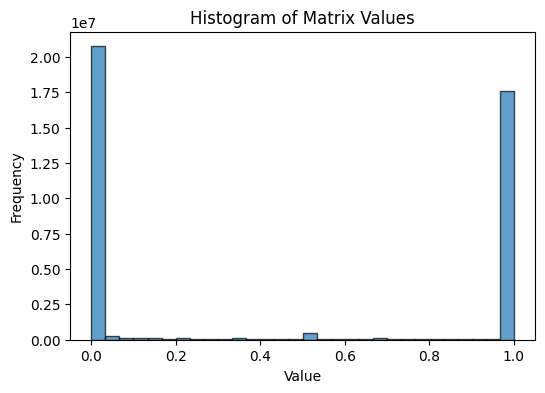

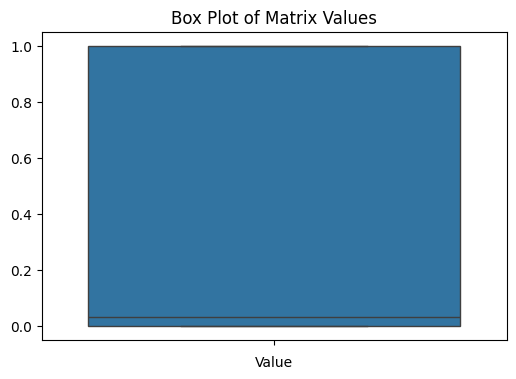

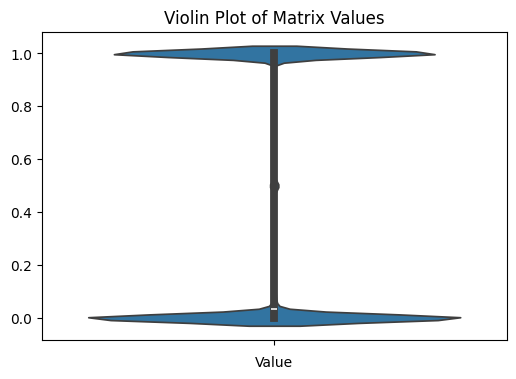

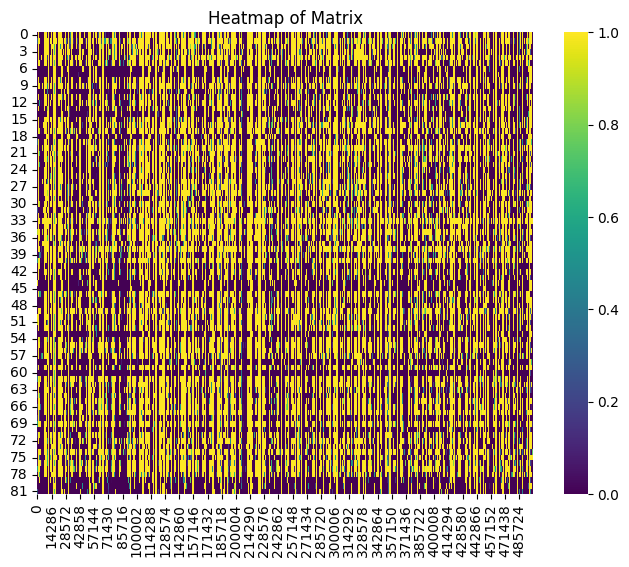

In [9]:
# Flatten the matrix to a 1D array for distribution plots
data = df.values.flatten()

# 1. Histogram
plt.figure(figsize=(6, 4))
plt.hist(data, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histogram of Matrix Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# 2. KDE Plot
# plt.figure(figsize=(6, 4))
# sns.kdeplot(data, bw_adjust=0.5)
# plt.title("KDE Plot of Matrix Values")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.show()

# 3. Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(data)
plt.title("Box Plot of Matrix Values")
plt.xlabel("Value")
plt.show()

# 4. Violin Plot
plt.figure(figsize=(6, 4))
sns.violinplot(data)
plt.title("Violin Plot of Matrix Values")
plt.xlabel("Value")
plt.show()

# 5. Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.values, cmap="viridis")
plt.title("Heatmap of Matrix")
plt.show()

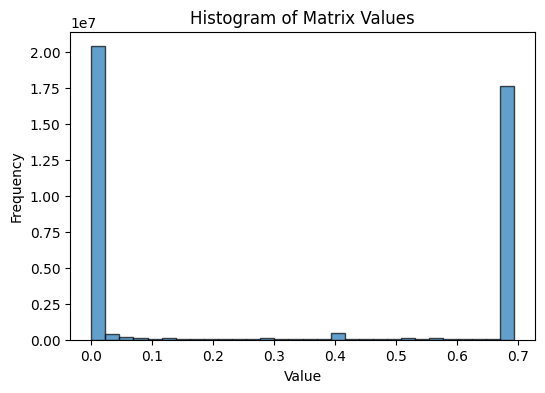

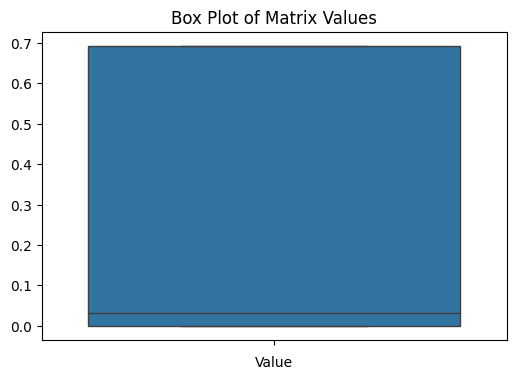

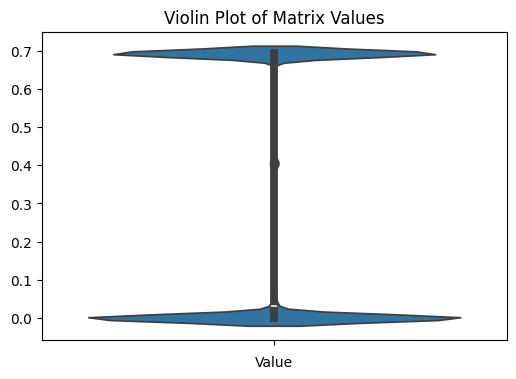

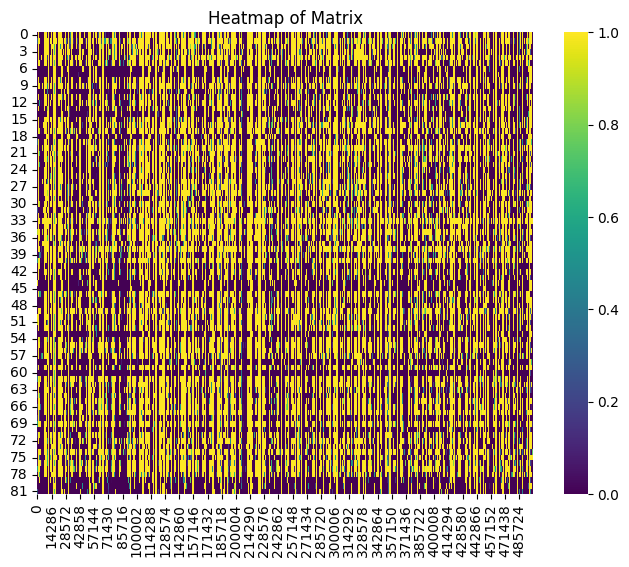

In [10]:
# Flatten the matrix to a 1D array for distribution plots
data = np.log1p(df.values.flatten())

# 1. Histogram
plt.figure(figsize=(6, 4))
plt.hist(data, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histogram of Matrix Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# 2. KDE Plot
# plt.figure(figsize=(6, 4))
# sns.kdeplot(data, bw_adjust=0.5)
# plt.title("KDE Plot of Matrix Values")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.show()

# 3. Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(data)
plt.title("Box Plot of Matrix Values")
plt.xlabel("Value")
plt.show()

# 4. Violin Plot
plt.figure(figsize=(6, 4))
sns.violinplot(data)
plt.title("Violin Plot of Matrix Values")
plt.xlabel("Value")
plt.show()

# 5. Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.values, cmap="viridis")
plt.title("Heatmap of Matrix")
plt.show()

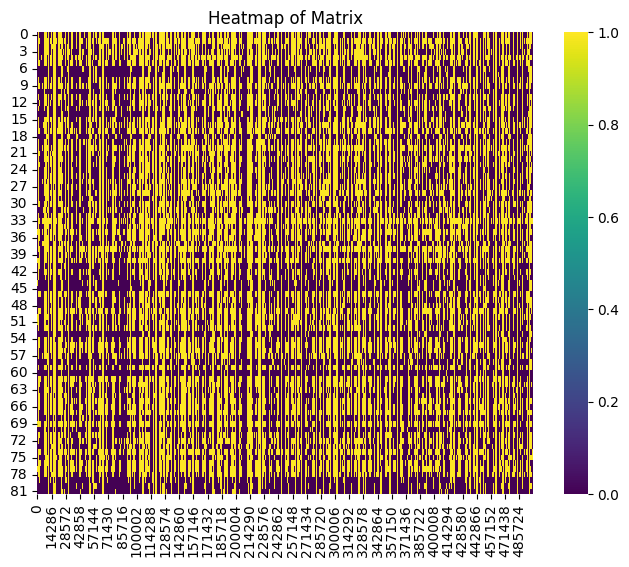

In [11]:
# binarize the data
df1 = df.applymap(lambda x: 1 if x > 0.5 else 0)
# 5. Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df1.values, cmap="viridis")
plt.title("Heatmap of Matrix")
plt.show()

In [12]:
# Find mutual information between features and target
# import mutrual info gain
from sklearn.feature_selection import mutual_info_classif
# make a progress bar
mi = mutual_info_classif(X, Y)
mi

array([0.03212292, 0.        , 0.04946313, ..., 0.01680233, 0.        ,
       0.07180255])

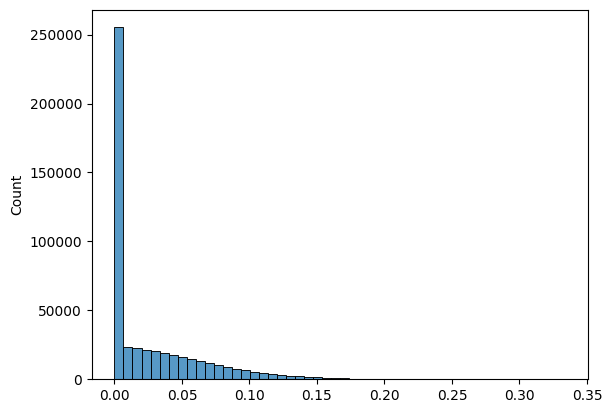

In [13]:
# Make plots of the mutual information
import matplotlib.pyplot as plt
import seaborn as sns
# make a progress bar
sns.histplot(mi, bins=50)
plt.show()

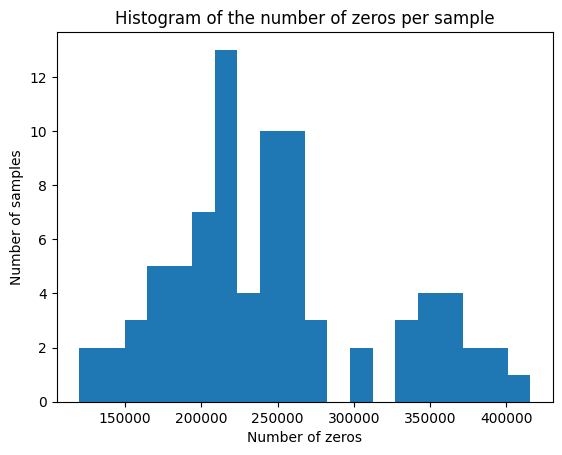

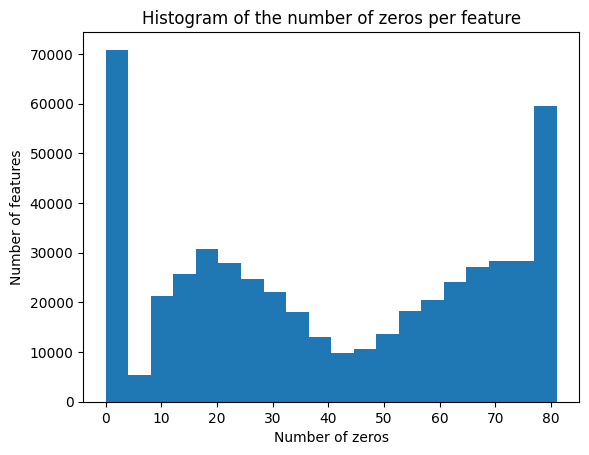

In [14]:
# Make an histogram of the number of zeros per sample
plt.hist(np.sum(df == 0, axis=1), bins=20)
plt.xlabel('Number of zeros')
plt.ylabel('Number of samples')
plt.title('Histogram of the number of zeros per sample')
plt.show()
plt.close()
# Make an histogram of the number of zeros per feature
plt.hist(np.sum(df == 0, axis=0), bins=20)
plt.xlabel('Number of zeros')
plt.ylabel('Number of features')
plt.title('Histogram of the number of zeros per feature')
plt.show()
plt.close()


In [15]:
# Fucntion to get test scores
def get_test_predictions(reg, X_train, X_train2, X_test, y_train2, y_test, scores):
    reg = reg.fit(X_train2, y_train2)
    y_pred = reg.predict(X_test)
    y_pred_train = reg.predict(X_train)

    acc = metrics.accuracy_score(y_test, y_pred)
    mcc = metrics.matthews_corrcoef(y_test, y_pred)
    scores = [acc, mcc]
        
    # Build scatterplot
    # plt.scatter(y_train, y_pred_train, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
    # plt.scatter(y_test, y_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
    # plt.xlabel('Rdm')
    # plt.ylabel('Pred')
    # plt.grid(color = '#D3D3D3', linestyle = 'solid')
    # plt.legend(loc = 'lower right')
    # plt.show()
    return scores

def get_predictions(reg, X_train, X_train2, X_test, y_train, y_train2, y_test, name):
    reg = reg.fit(X_train2, y_train2)
    y_pred = reg.predict(X_test)
    y_pred_train = reg.predict(X_train)

    acc = metrics.accuracy_score(y_test, y_pred)
    mcc = metrics.matthews_corrcoef(y_test, y_pred)
    scores = [acc, mcc]
    


In [16]:
def process_model(model, data, model_name, exp_name, hp, space, table, n_calls=10, n_splits=10):
    train = Train(model, model_name, exp_name, data, hp, mi, n_splits=n_splits, n_calls=n_calls)
    res = gp_minimize(train.train, space, n_calls=n_calls, random_state=41)

    plot_convergence(res)
    plt.show()
    try:
        plot_evaluations(res)
        plt.show()
    except:
        pass
    try:
        plot_objective(res)
        plt.show()
    except:
        pass
    try:
        plot_regret(res)
        plt.show()
    except:
        pass
    
    # param_grid = {}
    # for name, param in zip(hp, res.x):
    #     if name == 'n_aug':
    #         n_aug = param
    #     elif name == 'scaler':
    #         scaler = param
    #     else:
    #         param_grid[name] = param
    # scaler = get_scaler(scaler)()
    return res
    

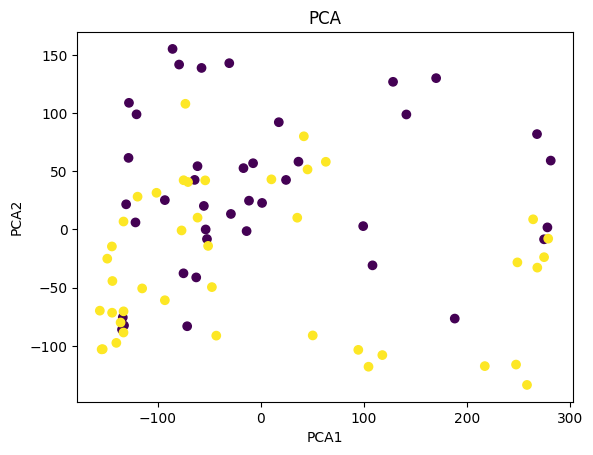

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.


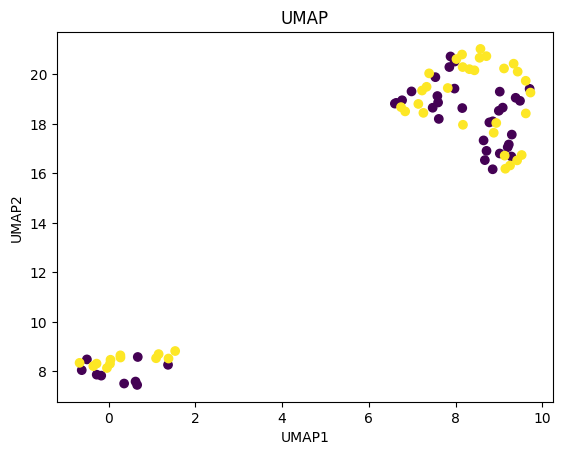

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.


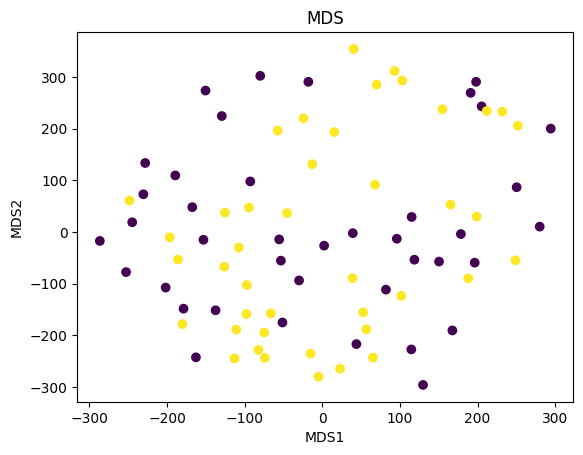

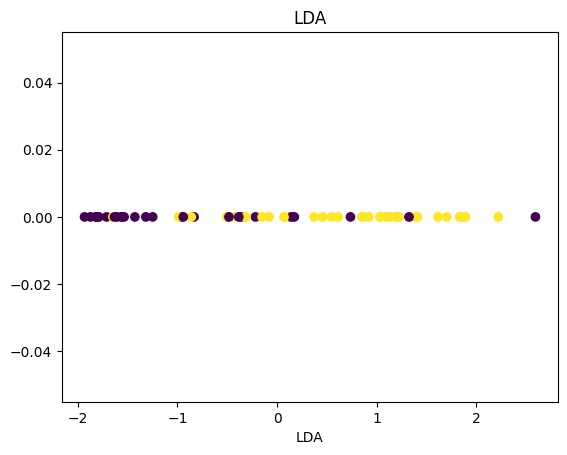

Test score with LDA: 0.4497006112188861
Train score with LDA: 0.564176245210728


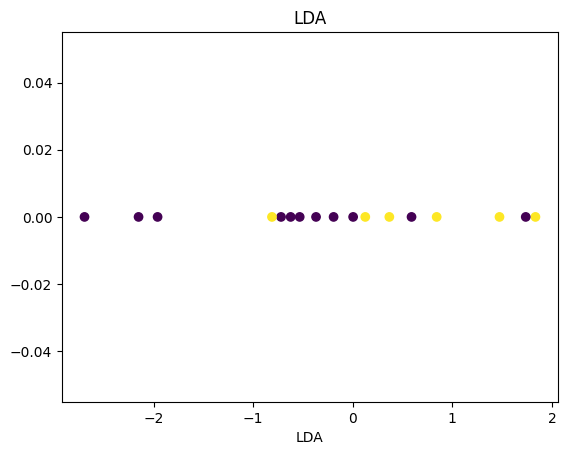

Variables are collinear


Test score with QDA: 0.26967994498529685
Train score with QDA: 1.0


In [17]:
# Ordinations
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA')
plt.show()
plt.close()

# UMAP
from umap import UMAP
umap = UMAP(n_components=2)
X_umap = umap.fit_transform(X)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=Y)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP')
plt.show()
plt.close()

# NMDS
from sklearn.manifold import MDS
mds = MDS(n_components=2)
X_mds = mds.fit_transform(X)
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=Y)
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')
plt.show()
plt.close()

# USE LDA after splitting the data
lda = LinearDiscriminantAnalysis(n_components=1)
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_lda = lda.fit_transform(X_train, y_train)
plt.scatter(X_lda, np.zeros(X_lda.shape), c=y_train)
plt.xlabel('LDA')
plt.title('LDA')
plt.show()
plt.close()

# Test scores with LDA
valid_LDA = lda.transform(X_test)
test_score = lda.score(X_test, y_test)
# MCC
test_mcc = metrics.matthews_corrcoef(y_test, lda.predict(X_test))
train_mcc = metrics.matthews_corrcoef(y_train, lda.predict(X_train))
print('Test score with LDA:', test_mcc)
print('Train score with LDA:', train_mcc)
plt.scatter(valid_LDA, np.zeros(valid_LDA.shape), c=y_test)
plt.xlabel('LDA')
plt.title('LDA')
plt.show()
plt.close()

# Test scores with QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
train_score = qda.score(X_train, y_train)
test_score = qda.score(X_test, y_test)
# valid_QDA = qda.transform(X_test)
# MCC
test_mcc = metrics.matthews_corrcoef(y_test, qda.predict(X_test))
train_mcc = metrics.matthews_corrcoef(y_train, qda.predict(X_train))
print('Test score with QDA:', test_mcc)
print('Train score with QDA:', train_mcc)
# plt.scatter(valid_QDA, np.zeros(valid_LDA.shape), c=y_test)


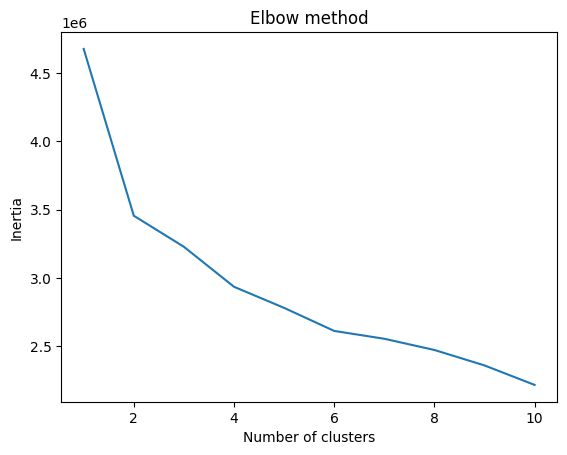

In [18]:
# kmeans with 1 to 10 clusters
from sklearn.cluster import KMeans
inertia = []
clusters = {}
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    clusters[i] = kmeans.labels_
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()
plt.close()


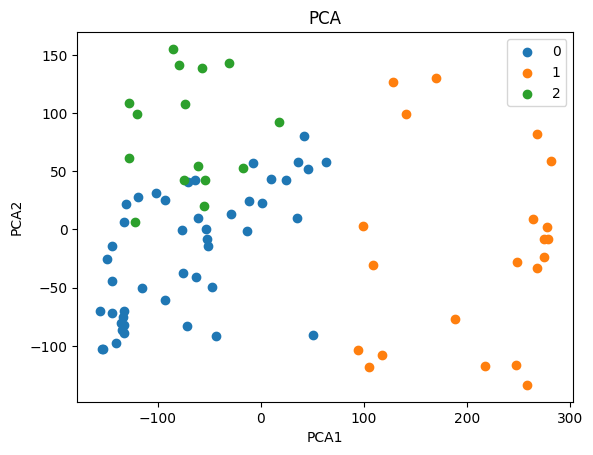

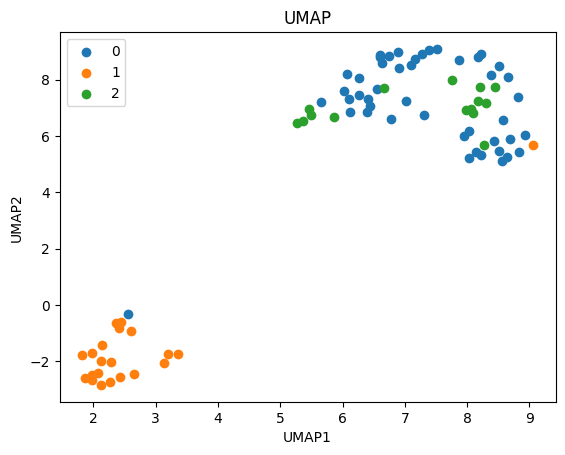

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.


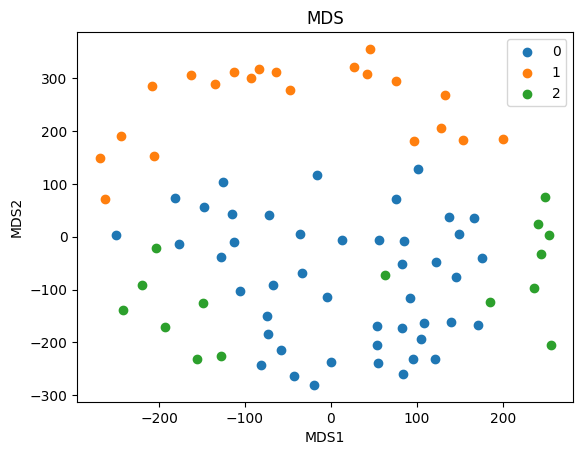

In [19]:
# Ordinations

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
for label in np.unique(clusters[3]):
    plt.scatter(X_pca[clusters[3] == label, 0], X_pca[clusters[3] == label, 1], label=label)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA')
plt.legend()
plt.show()
plt.close()

# UMAP
from umap import UMAP
umap = UMAP(n_components=2)
X_umap = umap.fit_transform(X)

for label in np.unique(clusters[3]):
    plt.scatter(X_umap[clusters[3] == label, 0], X_umap[clusters[3] == label, 1], label=label)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP')
plt.legend()
plt.show()
plt.close()

# NMDS
from sklearn.manifold import MDS
mds = MDS(n_components=2)
X_mds = mds.fit_transform(X)

for label in np.unique(clusters[3]):
    plt.scatter(X_mds[clusters[3] == label, 0], X_mds[clusters[3] == label, 1], label=label)

plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('MDS')
plt.legend()
plt.show()
plt.close()



# Defining spaces and names

In [20]:
# Sort the features by mutual information
from operator import itemgetter
sorted_mi = sorted(enumerate(mi), key=itemgetter(1))
sorted_mi = [x[0] for x in sorted_mi]
X_sorted = X.iloc[:, sorted_mi]


In [21]:
# For some reason, xgboost stopped working on my device...

# to cancel the effects of groupKFold, the groups are the indices, which are unique. 
data = {"X": X_sorted.copy(), "y": Y.copy(), 'group': pd.Series(list(X.index)), "clusters": clusters[3]}  
# When bagging, the hparams for svr are before n_aug. The hparams for the ensemble model are after f
hparam_names = {
    # 'lda': ["n_aug", "p", "g", "scaler", "zeros_cutoff", "features_cutoff"],
    # 'lda': ["n_aug", "p", "g", "scaler", "zeros_cutoff", "features_cutoff"],
    # 'qda': ["n_aug", "p", "g", "scaler", "zeros_cutoff", "features_cutoff"],
    # 'qda': ["n_aug", "p", "g", "scaler", "zeros_cutoff", "features_cutoff"],
    # 'knr': ["n_aug", "p", "g", "n_neighbors", "scaler", "zeros_cutoff", "features_cutoff"],
    # 'knr': ["n_aug", "p", "g", "n_neighbors", "scaler", "zeros_cutoff", "features_cutoff"],
    # 'linreg': ["n_aug", "p", "g", "scaler"],
    'xgb': ["n_aug", "p", "g", "max_depth", "eta","min_child_weight",
            "max_delta_step", "gamma", "subsample", "scaler", "zeros_cutoff", "features_cutoff"],
    'rfr': ["n_aug", "p", "g", "max_depth", 
            "max_samples", "min_samples_split", "min_samples_leaf", 
            "n_estimators", "oob_score", "scaler", "zeros_cutoff", "features_cutoff"],
    # 'gbr': ["n_aug", "p", "g", "max_depth", 
    #         "min_samples_split", "learning_rate",
    #           "n_estimators", "loss", "scaler",
    #           "zeros_cutoff", "features_cutoff"],
    'svr': ["n_aug", "p", "g", 'tol', 'kernel', 'C',
             "scaler", "zeros_cutoff", "features_cutoff"],
    # 'bagging_svr': ['tol', 'kernel', 'C', "n_aug", "p",
    #                  "g", "max_samples",
    #                    "n_estimators", "oob_score", "scaler", "zeros_cutoff", "features_cutoff"],
    # 'bagging_linreg': ["n_aug", "p", "g", "features_cutoff", "max_samples", "n_estimators", "oob_score", "scaler"],
    # 'xgb': ["n_aug", "p", "g", "max_depth", "eta","min_child_weight", "max_delta_step", "gamma", "subsample", "scaler"],
}
spaces = {
    # 'lda': [
    #     Integer(0, 5, 'uniform', name="n_aug"),
    #     Real(0, 0.1, 'uniform', name="p"),
    #     Real(0, 0.1, 'uniform', name="g"),
    #     # Real(0, 5, 'uniform', name="f"),
    #     Categorical(['binary', 'minmax', 'standard', 'robust'], name="scaler"),
    #     Real(0.01, 1, 'uniform', name="zeros_cutoff"),
    #     Real(0.01, 1, 'uniform', name="features_cutoff"),
    # ],
    # "qda": [
    #     Integer(0, 5, 'uniform', name="n_aug"),
    #     Real(0, 0.1, 'uniform', name="p"),
    #     Real(0, 0.1, 'uniform', name="g"),
    #     # Real(0, 5, 'uniform', name="f"),
    #     Categorical(['binary', 'minmax', 'standard', 'robust'], name="scaler"),
    #     Real(0.01, 1, 'uniform', name="zeros_cutoff"),
    #     Real(0.01, 1, 'uniform', name="features_cutoff"),
    # ],
    # 'knr': [
    #     Integer(0, 5, 'uniform', name="n_aug"),
    #     Real(0, 0.1, 'uniform', name="p"),
    #     Real(0, 0.1, 'uniform', name="g"),
    #     # Real(0, 5, 'uniform', name="f"),
    #     Integer(1, 5, 'uniform', name="n_neighbors"),
    #     Categorical(['binary', 'minmax', 'standard', 'robust'], name="scaler"),
    #     Real(0.01, 1, 'uniform', name="zeros_cutoff"),
    #     Real(0.01, 1, 'uniform', name="features_cutoff"),
    # ],
    'xgb': [
        Integer(0, 5, 'uniform', name="n_aug"),
        Real(0, 0.1, 'uniform', name="p"),
        Real(0, 0.1, 'uniform', name="g"),
        # Real(0, 5, 'uniform', name="f"),
        Integer(1, 20, 'uniform', name="max_depth"),
        Real(1e-4, 1e-1, 'uniform', name="eta"),
        Real(0, 10, 'uniform', name="min_child_weight"),
        Real(0, 10, 'uniform', name="max_delta_step"),
        Real(0, 10, 'uniform', name="gamma"),
        Real(0, 1, 'uniform', name="subsample"),
        Categorical(['binary', 'minmax', 'standard', 'robust'], name="scaler"),
        Real(0.01, 1, 'uniform', name="zeros_cutoff"),
        Real(0.01, 0.1, 'uniform', name="features_cutoff"),
    ],
    # 'linreg': [
    #     Integer(0, 100, 'uniform', name="n_aug"),
    #     Real(0, 0.5, 'uniform', name="p"),
    #     Real(0, 5, 'uniform', name="g"),
    #     Real(0, 5, 'uniform', name="f"),
    #     Categorical(['standard', 'robust'], name="scaler")
    # ],
    'rfr': [
        Integer(0, 5, 'uniform', name="n_aug"),
        Real(0, 0.1, 'uniform', name="p"),
        Real(0, 0.1, 'uniform', name="g"),
        # Real(0, 5, 'uniform', name="f"),
        Integer(10, 100, 'uniform', name="max_depth"),
        Real(0.1, 1, 'uniform', name="max_samples"),
        Integer(2, 10, 'uniform', name="min_samples_split"),
        Integer(1, 10, 'uniform', name="min_samples_leaf"),
        Integer(1, 100, 'uniform', name="n_estimators"),
        # Categorical(["squared_error", "absolute_error", "friedman_mse", "poisson"], name="criterion"),
        Categorical([False], name="oob_score"),
        Categorical(['binary', 'minmax', 'standard', 'robust'], name="scaler"),
        Real(0.01, 1, 'uniform', name="zeros_cutoff"),
        Real(0.01, 1, 'uniform', name="features_cutoff"),
    ],
    # 'gbr': [
    #     Integer(0, 5, 'uniform', name="n_aug"),
    #     Real(0, 0.5, 'uniform', name="p"),
    #     Real(0, 5, 'uniform', name="g"),
    #     Real(0, 5, 'uniform', name="f"),
    #     Integer(1, 100, 'uniform', name="max_depth"),
    #     Integer(2, 10, 'uniform', name="min_samples_split"),
    #     Real(1e-4, 1e-1, 'uniform', name="learning_rate"),
    #     Integer(1, 10, 'uniform', name="n_estimators"),
    #     # Categorical(["squared_error", "absolute_error", "friedman_mse", "poisson"], name="criterion"),
    #     Categorical(["log_loss"], name="loss"),
    #     Categorical(['binary', 'minmax', 'standard', 'robust'], name="scaler"),
    #     Real(0.01, 1, 'uniform', name="zeros_cutoff"),
    #     Real(0.01, 1, 'uniform', name="features_cutoff"),
    # ],
    'svr': [
        Integer(0, 1, 'uniform', name="n_aug"),
        Real(0, 0.1, 'uniform', name="p"),
        Real(0, 0.1, 'uniform', name="g"),
        # Real(0, 5, 'uniform', name="f"),
        Real(1e-4, 1, 'log-uniform', name='tol'),
        # Real(0, 1, 'uniform', name='epsilon'),
        # Integer(1, 100000, 'uniform', name='max_iter'),
        Categorical(['linear', 'rbf', 'poly'], name='kernel'),
        Real(1e-3, 100, 'uniform', name='C'),
        Categorical(['binary', 'minmax', 'standard', 'robust'], name="scaler"),
        Real(0.01, 1, 'uniform', name="zeros_cutoff"),
        Real(0.01, 1, 'uniform', name="features_cutoff"),
    ],
    # 'bagging_svr': [
    #     Real(1e-4, 1, 'log-uniform', name='tol'),
    #     # Real(0, 1, 'uniform', name='epsilon'),
    #     # Integer(1, 100000, 'uniform', name='max_iter'),
    #     Categorical(['linear', 'rbf', 'poly'], name='kernel'),
    #     Real(1e-3, 100, 'uniform', name='C'),
    #     Integer(0, 1, 'uniform', name="n_aug"),
    #     Real(0, 0.5, 'uniform', name="p"),
    #     Real(0, 5, 'uniform', name="g"),
    #     Real(0, 5, 'uniform', name="f"),
    #     # Real(0.01, 1, 'uniform', name="features_cutoff"),
    #     Real(0.1, 1, 'uniform', name="max_samples"),
    #     Integer(1, 10, 'uniform', name="n_estimators"),
    #     # Categorical([LinearRegression], name="base_estimator"),
    #     # Categorical(["squared_error", "absolute_error", "friedman_mse", "poisson"], name="criterion"),
    #     Categorical([False], name="oob_score"),
    #     Categorical(['binary', 'minmax', 'standard', 'robust'], name="scaler"),
    #     Real(0.01, 1, 'uniform', name="zeros_cutoff"),
    #     Real(0.01, 1, 'uniform', name="features_cutoff"),
    # ],
    # 'xgb': [
    #     Integer(0, 5, 'uniform', name="n_aug"),
    #     Real(0, 0.3, 'uniform', name="p"),
    #     Real(0, 5, 'uniform', name="g"),
    #     Real(0, 5, 'uniform', name="f"),
    #     Integer(1, 200, 'uniform', name="max_depth"),
    #     # Integer(2, 10, 'uniform', name="min_samples_split"),
    #     Real(1e-4, 1e-1, 'uniform', name="eta"),
    #     Real(0, 10, 'uniform', name="min_child_weight"),
    #     Real(0, 10, 'uniform', name="max_delta_step"),
    #     Real(0, 10, 'uniform', name="gamma"),
    #     Real(0, 1, 'uniform', name="subsample"),
    #     Categorical(['standard', 'robust'], name="scaler")
    # ],

}
models = [
    # LinearDiscriminantAnalysis(),
    # QuadraticDiscriminantAnalysis(),
    # KNeighborsClassifier(),
    xgb.XGBClassifier(),
    # LinearRegression(),
    RandomForestClassifier(),
    # GradientBoostingClassifier(),
    SVC(),
    # BaggingClassifier(SVC()),
    # BaggingClassifier(LinearRegression()),
    # XGBClassifier(),

]


In [ ]:
from tabulate import tabulate
table = [['Model', 'valid_MCC']]
experiment_name = f'{experiment_name}_{n_features}features'    
for model, name in zip(models, list(spaces.keys())):
    display(Markdown(f"##{name}"))
    # n_splits=5 serait mieux mais coince
    table = process_model(model, data, name, experiment_name, hparam_names[name], spaces[name], table, n_calls=20, n_splits=5) 
    fig = plt.figure()


##xgb

  0%|          | 0/20 [00:00<?, ?it/s]

hparams: {'n_aug': 3, 'p': 0.032097339389336295, 'g': 0.015535934301815539, 'max_depth': 12, 'eta': 0.09244338800703127, 'min_child_weight': 7.878644108096561, 'max_delta_step': 7.638307636120598, 'gamma': 7.029740059185613, 'subsample': 0.8339391232936092, 'scaler': 'robust', 'zeros_cutoff': 0.1872384419307358, 'features_cutoff': 0.05142970432911371}
0


In [ ]:
# No feature reduction
print(tabulate(table))

In [ ]:
# Features agglomeration with 64 clusters
print(tabulate(table))

In [18]:
# Permutation test score

In [19]:
from sklearn.model_selection import permutation_test_score

rfr = RandomForestClassifier(random_state=101)
param_grid = {'features_cutoff': 0.3, 'max_samples': 0.7874476872508538, 'min_samples_split': 8, 'min_samples_leaf': 9, 'n_estimators': 80, 'oob_score': False}
rfr.set_params(**param_grid)
cv = StratifiedKFold(5, shuffle=True, random_state=0)

score, perm_scores, pvalue = permutation_test_score(
    rfr, X, Y, scoring="neg_mcc", cv=cv, n_permutations=100
)


In [ ]:
fig, ax = plt.subplots(1)

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(-10.5, 2, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
plt.show()